In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pybamm
import pandas as pd
import timeit
start = timeit.default_timer()
pybamm.set_logging_level("INFO")

In [8]:
def electrolyte_conductivity_Valoen2005(c_e, T):
    # T = T + 273.15
    # mol/m3 to molar
    c_e = c_e / 1000
    # mS/cm to S/m
    return (1e-3 / 1e-2) * (
        c_e
        * (
            (-10.5 + 0.0740 * T - 6.96e-5 * T ** 2)
            + c_e * (0.668 - 0.0178 * T + 2.80e-5 * T ** 2)
            + c_e ** 2 * (0.494 - 8.86e-4 * T)
        )
        ** 2
    )
def electrolyte_diffusivity_Valoen2005(c_e, T):
    # T = T + 273.15
    # mol/m3 to molar
    c_e = c_e / 1000

    T_g = 229 + 5 * c_e
    D_0 = -4.43 - 54 / (T - T_g)
    D_1 = -0.22

    # cm2/s to m2/s
    # note, in the Valoen paper, ln means log10, so its inverse is 10^x
    return (10 ** (D_0 + D_1 * c_e)) * 1e-4

In [9]:
model = pybamm.lithium_ion.DFN(
    options={
        "thermal": "lumped",
        "SEI": "interstitial-diffusion limited",
        "SEI on cracks": "true",
        "SEI film resistance": "distributed", 
        "SEI porosity change": "true",
        "particle mechanics": ("swelling and cracking", "swelling only"),
        "loss of active material": "stress-driven",
        "lithium plating": "partially reversible"
    }
)
param = pybamm.ParameterValues("OKane2023")
# Adjust SEI parameters
param.update({"Inner SEI lithium interstitial diffusivity [m2.s-1]": 3e-19})
# Override SEI thickness dependence of lithium plating
param.update({"Dead lithium decay rate [s-1]": 1e-6})
param.update({"Lithium plating kinetic rate constant [m.s-1]": 1e-10})
# Adjust mechanical degradation parameters
param.update({"Negative electrode cracking rate": 1e-22})
param.update({"Negative electrode LAM constant proportional term [s-1]": 1e-9})
param.update({"Positive electrode LAM constant proportional term [s-1]": 1e-9})
param.update({"Electrolyte conductivity [S.m-1]": electrolyte_conductivity_Valoen2005})
param.update({"Electrolyte diffusivity [m2.s-1]": electrolyte_diffusivity_Valoen2005})

2023-02-22 23:55:43.134 - [INFO] base_model._build_model(550): Start building Doyle-Fuller-Newman model
2023-02-22 23:55:43.264 - [INFO] base_battery_model.build_model(955): Finish building Doyle-Fuller-Newman model


In [10]:
# define experiment
V_max = 4.2;        V_min = 2.5; 
Update_Cycles = 10; RPT_Cycles = 1;
charge_time_mins = 60 * 4.86491/5
exp_AGE_text = [(
    f"Charge at 0.3 C for {charge_time_mins} minutes",
    f"Discharge at 1 C until {V_min} V", 
    ),  ]
# step index for ageing
step_AGE_CD =0;   step_AGE_CC =1;   step_AGE_CV =2;

exp_RPT_text = [ (
    f"Charge at 1C until {V_max} V",  
    f"Hold at {V_max}V until C/100",
    f"Discharge at 0.1C until {V_min} V (5 minute period)",  
    "Rest for 1 hours (5 minute period)",  
    f"Charge at 0.1C until {V_max} V (5 minute period)",
    "Rest for 1 hours (5 minute period)",
    f"Discharge at 1C until {V_min} V",  
    f"Hold at {V_min} V until C/100",
    ) ]
# step index for RPT
step_RPT_CD = 2;  step_RPT_RE =3;   step_RPT_CC = 4;  
Experiment_Long   = pybamm.Experiment( exp_AGE_text * Update_Cycles  )  
Experiment_RPT    = pybamm.Experiment( exp_RPT_text * RPT_Cycles     ) 
Experiment_Breakin= pybamm.Experiment( exp_RPT_text * RPT_Cycles     )


In [11]:
var_pts = {
    "x_n": 5,  # negative electrode
    "x_s": 5,  # separator 
    "x_p": 5,  # positive electrode
    "r_n": 60,  # negative particle
    "r_p": 20,  # positive particle
}

In [12]:
sim1 = pybamm.Simulation(
    model, 
    experiment=Experiment_Breakin,
    parameter_values=param,
    solver=pybamm.CasadiSolver(),
    var_pts=var_pts,
)
solution1 = sim1.solve(
    save_at_cycles=1
)

stop = timeit.default_timer()
print('running time: ' + str(stop - start) +'s')

2023-02-22 23:55:43.554 - [INFO] callbacks.on_experiment_start(166): Start running experiment
2023-02-22 23:55:43.557 - [INFO] parameter_values.process_model(425): Start setting parameters for Doyle-Fuller-Newman model
2023-02-22 23:55:43.775 - [INFO] parameter_values.process_model(527): Finish setting parameters for Doyle-Fuller-Newman model
2023-02-22 23:55:43.778 - [INFO] parameter_values.process_model(425): Start setting parameters for Doyle-Fuller-Newman model
2023-02-22 23:55:43.977 - [INFO] parameter_values.process_model(527): Finish setting parameters for Doyle-Fuller-Newman model
2023-02-22 23:55:43.979 - [INFO] parameter_values.process_model(425): Start setting parameters for Doyle-Fuller-Newman model
2023-02-22 23:55:44.231 - [INFO] parameter_values.process_model(527): Finish setting parameters for Doyle-Fuller-Newman model
2023-02-22 23:55:44.232 - [INFO] parameter_values.process_model(425): Start setting parameters for Doyle-Fuller-Newman model
2023-02-22 23:55:44.401 - [I

running time: 80.3808467s


In [13]:
model_2 = model.set_initial_conditions_from(solution1, inplace=False)
sim2 = pybamm.Simulation(
    model_2, 
    experiment=Experiment_Long,
    parameter_values=param,
    solver=pybamm.CasadiSolver(),
    var_pts=var_pts,
)
solution2 = sim2.solve(
    save_at_cycles=[1,5,10] 
)

2023-02-22 23:57:03.139 - [INFO] callbacks.on_experiment_start(166): Start running experiment
2023-02-22 23:57:03.141 - [INFO] parameter_values.process_model(425): Start setting parameters for Doyle-Fuller-Newman model
2023-02-22 23:57:03.469 - [INFO] parameter_values.process_model(527): Finish setting parameters for Doyle-Fuller-Newman model
2023-02-22 23:57:03.470 - [INFO] parameter_values.process_model(425): Start setting parameters for Doyle-Fuller-Newman model
2023-02-22 23:57:03.643 - [INFO] parameter_values.process_model(527): Finish setting parameters for Doyle-Fuller-Newman model
2023-02-22 23:57:03.646 - [INFO] discretisation.process_model(148): Start discretising Doyle-Fuller-Newman model
2023-02-22 23:57:03.676 - [INFO] discretisation.remove_independent_variables_from_rhs(1123): removing variable Discharge capacity [A.h] from rhs
2023-02-22 23:57:03.677 - [INFO] discretisation.remove_independent_variables_from_rhs(1123): removing variable Throughput capacity [A.h] from rhs


In [14]:
# plot SOH, LAM, LII
# SOH must be defined ourselves? 

In [15]:
label = ["Initial solution","Second solution"] 
var = [
    "Loss of lithium inventory, including electrolyte [%]",
    "LAM_ne [%]",
    "Loss of active material in negative electrode [%]",
    "LAM_pe [%]",
    "Loss of active material in positive electrode [%]",
    'LLI [%]', 
    'Throughput capacity [A.h]',
    "Discharge capacity [A.h]"
]
quick_plot = pybamm.QuickPlot(
    [solution1,solution2], var,label,variable_limits='tight') #     
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=0.0, description='t', max=23.18110202262694, step=0.23181102022626943)…

In [16]:
print(solution2['Throughput capacity [A.h]'].entries[-1])
print(solution2.cycles[-1].steps[-1]['Throughput capacity [A.h]'].entries[-1])
print(solution2.cycles[-1].steps[1]['Throughput capacity [A.h]'].entries)

37.13094112775261
1.4594245896092446
[0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.45942459]


for step in solution2.cycles[-1].steps:
    step['Throughput capacity [A.h]'].entries += solution1['Throughput capacity [A.h]'].entries[-1]

In [17]:
# need to do this every time next solution is got:
solution2['Throughput capacity [A.h]'].entries += solution1['Throughput capacity [A.h]'].entries[-1]
"Throughput energy [W.h]",

('Throughput energy [W.h]',)

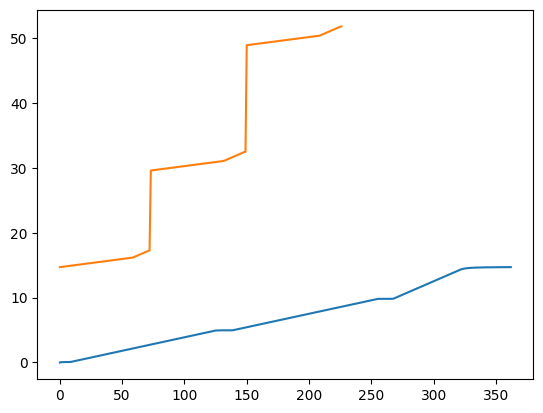

In [18]:
plt.plot(solution1['Throughput capacity [A.h]'].entries)
plt.plot(solution2['Throughput capacity [A.h]'].entries)

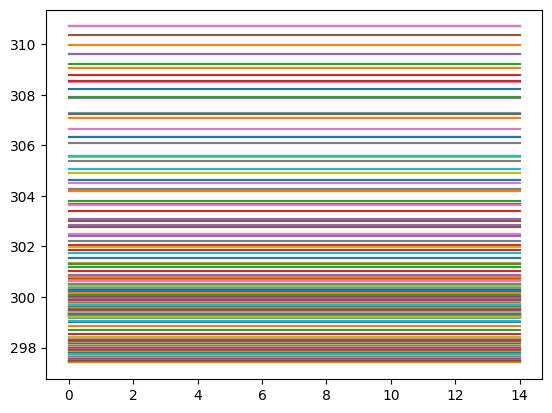

In [19]:
plt.plot(solution2['Cell temperature [K]'].entries )

In [20]:
solution2['Cell temperature [C]'].entries 

array([[27.64965534, 27.51688241, 27.35060074, ..., 36.48496954,
        37.22141411, 37.56022617],
       [27.64965534, 27.51688241, 27.35060074, ..., 36.48496954,
        37.22141411, 37.56022617],
       [27.64965534, 27.51688241, 27.35060074, ..., 36.48496954,
        37.22141411, 37.56022617],
       ...,
       [27.64965534, 27.51688241, 27.35060074, ..., 36.48496954,
        37.22141411, 37.56022617],
       [27.64965534, 27.51688241, 27.35060074, ..., 36.48496954,
        37.22141411, 37.56022617],
       [27.64965534, 27.51688241, 27.35060074, ..., 36.48496954,
        37.22141411, 37.56022617]])